In [1]:
import g3lhalo
import pyccl as ccl
import matplotlib.pyplot as plt
import numpy as np
import random
from pyDOE import lhs
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import os
from datetime import datetime
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.activations import gelu
from tensorflow.keras.losses import MeanSquaredError
import tensorflow_addons as tfa
import optuna
from tensorflow.keras.layers import LeakyReLU, ELU
from scipy.optimize import curve_fit

# Für spezielle Aktivierungen wie Swish, GELU
try:
    from tensorflow.keras.activations import swish, gelu
except ImportError:
    # Alternative falls alte TensorFlow-Version
    def swish(x): return x * tf.nn.sigmoid(x)
    def gelu(x): return 0.5 * x * (1.0 + tf.tanh(tf.sqrt(2.0 / tf.constant(np.pi)) * (x + 0.044715 * tf.pow(x, 3))))

# Für AdamW und RAdam Optimizer:
try:
    from tensorflow_addons.optimizers import AdamW, RectifiedAdam
except ImportError:
    # Falls nicht installiert:
    # pip install tensorflow-addons
    print("Installiere tensorflow-addons mit: pip install tensorflow-addons")

2025-07-05 14:14:00.058553: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-05 14:14:00.062424: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-05 14:14:00.109765: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-05 14:14:00.113308: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-05 14:14:04.788383: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [2]:
data_dir = "../Data/"
para_fn = f"{data_dir}Parameter_10000000_2025-05-20_00-09-40.json"
# Read in
with open(para_fn, "r") as json_file:
    samples = json.load(json_file)


# Create numpy arrays for each of the parameter columns
feature_keys = ['Om_c', 'Om_b', 'h', 'sigma_8', 'n_s', 'alpha', 'sigma', 'Mth', 'Mprime', 'beta']

# List of arrays for each parameter
feature_array = {key: np.array([sample[key] for sample in samples]) for key in feature_keys}

features = np.array(list(zip(*feature_array.values())))


In [3]:
log_indices = [7, 8]  # Ersetze mit deinen echten Indizes

features[:, log_indices] = np.log10(features[:, log_indices])

print("input min/max:", features.min(), features.max())

input min/max: 5.841504783488005e-09 16.999999990110187


In [ ]:
print('number of training features:', len(features))


number of training features: 10000000


In [5]:
mean_features = []
std_features = []

# Calculate mean and standard deviation for training features
for i in range(len(features[0])):  # for all 3-Halo terms
    feature_parameter = np.array(features[:,i])
    
    mean = np.mean(feature_parameter, axis=0)  # mean over complete training sample for every k-value
    std = np.std(feature_parameter, axis=0)    # standard deviation over complete training sample for every k-value
    
    mean_features.append(mean)
    std_features.append(std)



In [6]:
# Calculate mean and standard deviation **only from the training data**
feature_processing_vectors = {
    'mean': np.array(mean_features).reshape(1, -1),
    'sigma': np.array(std_features).reshape(1, -1)
}


# Ensure that no division by zero occurs
feature_processing_vectors['sigma'][feature_processing_vectors['sigma'] == 0] = 1  

# Preprocessing function
def preprocessing(features, processing_vectors):
    return (features - processing_vectors['mean']) / processing_vectors['sigma']

# Postprocessing function
def postprocessing(features, processing_vectors):
    return features * processing_vectors['sigma'] + processing_vectors['mean']

# Apply preprocessing to all data
features_rescaled = preprocessing(features, feature_processing_vectors)

# JSON-compatible storage of the processing vectors
#serializable_processing_vectors = {key: value.tolist() for key, value in processing_vectors.items()}
#processing_out="../Emulators/NM_processing_vectors.json"
#with open(processing_out, "w") as json_file:
#    json.dump(serializable_processing_vectors, json_file)

# Check shapes after the transformation
print("Train Rescaled Shape:", features_rescaled.shape)



Train Rescaled Shape: (10000000, 10)


In [7]:
#load
timestamp = '2025-06-24_11-16-02' 

model = keras.models.load_model(
    f'../NN_builds/NN_{timestamp}.keras',
    compile=False
)
model.compile(optimizer=RectifiedAdam(), loss='mse')


In [8]:
data_sizes_pred = [100, 1000, 10000, 50000, 100000, 1000000, 10000000]
repetitions = 10
# Warm-up (ohne Zeitmessung)
data_subset_warmup = features_rescaled[:100]
_ = model.predict(data_subset_warmup)
def measure_prediction_time(model, data, data_size, repetitions=repetitions):
    # Dataset zuschneiden
    data_subset = data[:data_size]

    cpu_times = []
    for _ in range(repetitions):
        start = os.times()
        _ = model.predict(data_subset, batch_size=data_size)
        end = os.times()

        user_time = end.user - start.user
        cpu_times.append(user_time)

    avg_cpu_time = sum(cpu_times) / repetitions
    return avg_cpu_time

# Beispielaufruf:
# features_rescaled = ... # Deine Eingabedaten als numpy array
# model = ...            # Dein trainiertes Model

dataset_pred_time = np.array([])
for size in data_sizes_pred:
    avg_time = measure_prediction_time(model, features_rescaled, size, repetitions)
    dataset_pred_time = np.append(dataset_pred_time, avg_time)
    print(f"Datensatzgröße {size}: Durchschnittliche CPU-Zeit über {repetitions} Läufe = {avg_time:.4f} s")


1/1 [==============================] - 0s 72ms/step
Datensatzgröße 100: Durchschnittliche CPU-Zeit über 10 Läufe = 0.3740 s
1/1 [==============================] - 0s 164ms/step
Datensatzgröße 1000: Durchschnittliche CPU-Zeit über 10 Läufe = 1.2870 s
1/1 [==============================] - 0s 338ms/step
Datensatzgröße 10000: Durchschnittliche CPU-Zeit über 10 Läufe = 14.3760 s
1/1 [==============================] - 1s 876ms/step
Datensatzgröße 50000: Durchschnittliche CPU-Zeit über 10 Läufe = 60.0880 s
1/1 [==============================] - 1s 1s/step
Datensatzgröße 100000: Durchschnittliche CPU-Zeit über 10 Läufe = 105.8700 s
1/1 [==============================] - 6s 6s/step
Datensatzgröße 1000000: Durchschnittliche CPU-Zeit über 10 Läufe = 594.3140 s
1/1 [==============================] - 54s 54s/step
Datensatzgröße 10000000: Durchschnittliche CPU-Zeit über 10 Läufe = 6198.4450 s


In [ ]:
dataset_sizes_calc = np.array([100, 1000, 10000, 50000])
dataset_calc_time = np.array([1452.0900, 14464.3000, 150278.4200, 725533.9200])



Angepasste Funktion: t(x) = 1.4531e+01 * x


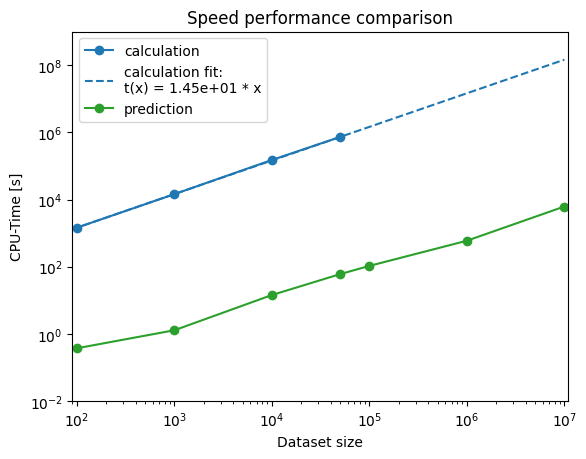

In [10]:
def power_law(x, a):
    return a * x


# do plot
fig, ax=plt.subplots()

ax.plot(dataset_sizes_calc, dataset_calc_time, color='C0', label=r'calculation', marker='o')
popt, pcov = curve_fit(power_law, dataset_sizes_calc, dataset_calc_time)
x_fit = np.logspace(1, 7, 100)
y_fit = power_law(x_fit, *popt)
a = popt[0]
ax.plot(x_fit, y_fit, '--', color='C0', label=f'calculation fit: \nt(x) = {a:.2e} * x')

ax.plot(data_sizes_pred, dataset_pred_time, color='C2', label=r'prediction', marker='o')



ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(90, 1.1e7)
ax.set_ylim(1e-2, 1e9)

ax.set_ylabel('CPU-Time [s]')
ax.set_xlabel('Dataset size')
ax.set_title('Speed performance comparison')


a = popt[0]
print(f"Angepasste Funktion: t(x) = {a:.4e} * x")

plt.legend()
plt.savefig(f'../Plots/FinalExamples/CpuTimeComparison.png', dpi=600)


In [11]:
# Modell-Zeitstempel (Dateinamen)

model1_date='2025-06-24_11-16-02' #test loss=0.001483, val loss=0.001149, params={'n_layers': 14, 'n_units': 888, 'activation': 'gelu', 'optimizer': 'RAdam', 'lr': 0.00049, 'batchsize': 1889}

model2_1halo_date='2025-06-15_02-54-08' #test loss=0.001870, val loss=0.001281, params={'n_layers': 10, 'n_units': 416, 'activation': 'gelu', 'optimizer': 'adam', 'lr': 0.001, 'batchsize': 1717}
model2_2halo_date='2025-06-18_00-05-20' #test loss=0.000790, val loss=0.000455, params={'n_layers': 13, 'n_units': 165, 'activation': 'swish', 'optimizer': 'adam', 'lr': 0.000997, 'batchsize': 1313}

model3_date='2025-05-18_18-07-15' #test loss=0.001998, validation loss=0.001020, params={'n_layers': 3, 'n_units': 478, 'activation': 'elu', 'optimizer': 'RAdam', 'lr': 0.00011, 'batchsize': 1712}

model4_1halo_date='2025-06-06_17-39-22' #test loss=0.004405, val loss=0.001415, params={'n_layers': 3, 'n_units': 432, 'activation': 'swish', 'optimizer': 'adam', 'lr': 0.0027, 'batchsize': 752}
model4_2halo_date='2025-06-19_11-58-01' #test loss=0.001681, val loss=0.001320, params={'n_layers': 2, 'n_units': 639, 'activation': 'swish', 'optimizer': 'adam', 'lr': 0.00208, 'batchsize': 1397}



# Modelle laden und kompilieren
model1 = keras.models.load_model(
    f'../NN_builds/NN_{model1_date}.keras',
    compile=False
)
model1.compile(optimizer=RectifiedAdam(), loss='mse')

model2_1halo = keras.models.load_model(
    f'../NN_builds/NN_{model2_1halo_date}.keras',
    compile=False
)
model2_1halo.compile(optimizer=RectifiedAdam(), loss='mse')

model2_2halo = keras.models.load_model(
    f'../NN_builds/NN_{model2_2halo_date}.keras',
    compile=False
)
model2_2halo.compile(optimizer=RectifiedAdam(), loss='mse')

model3 = keras.models.load_model(
    f'../NN_builds/NN_{model3_date}.keras',
    compile=False
)
model3.compile(optimizer=RectifiedAdam(), loss='mse')

model4_1halo = keras.models.load_model(
    f'../NN_builds/NN_{model4_1halo_date}.keras',
    compile=False
)
model4_1halo.compile(optimizer=RectifiedAdam(), loss='mse')

model4_2halo = keras.models.load_model(
    f'../NN_builds/NN_{model4_2halo_date}.keras',
    compile=False
)
model4_2halo.compile(optimizer=RectifiedAdam(), loss='mse')


# Trainingsverläufe laden
with open(f'../Traininghist/full_training_history_{model1_date}.json', 'r') as f:
    loaded_history_1 = json.load(f)

with open(f'../Traininghist/full_training_history_{model2_1halo_date}.json', 'r') as f:
    loaded_history_21 = json.load(f)

with open(f'../Traininghist/full_training_history_{model2_2halo_date}.json', 'r') as f:
    loaded_history_22 = json.load(f)

with open(f'../Traininghist/full_training_history_{model3_date}.json', 'r') as f:
    loaded_history_3 = json.load(f)

with open(f'../Traininghist/full_training_history_{model4_1halo_date}.json', 'r') as f:
    loaded_history_41 = json.load(f)

with open(f'../Traininghist/full_training_history_{model4_2halo_date}.json', 'r') as f:
    loaded_history_42 = json.load(f)

In [12]:
repetitions = 10  # Wiederholungen zur Mittelwert- und Fehlerabschätzung

def measure_prediction_time(model, data, data_size, repetitions=1):
    """Messe die durchschnittliche CPU-Zeit und Standardabweichung zur Vorhersage von data_size Samples."""
    data_subset = data[:data_size]
    cpu_times = []
    for _ in range(repetitions):
        start = os.times()
        _ = model.predict(data_subset, batch_size=data_size, verbose=0)
        end = os.times()
        user_time = end.user - start.user
        cpu_times.append(user_time)
    return np.mean(cpu_times), np.std(cpu_times)

# Warm-up
_ = model1.predict(features_rescaled[:100], batch_size=100, verbose=0)

# Dictionary mit allen Modellen
model_dict = {
    "Model 1": model1,
    "Model 2 (1+2 halo)": (model2_1halo, model2_2halo),
    "Model 3": model3,
    "Model 4 (1+2 halo)": (model4_1halo, model4_2halo),
}

# Ergebnisse speichern
model_prediction_times = {}
model_prediction_stds = {}

for name, model in model_dict.items():
    print(f"\n==> Messe Vorhersagezeiten für {name}")
    times = []
    stds = []

    for size in data_sizes_pred:
        if isinstance(model, tuple):
            # Kombiniertes Modell: beide Teile separat messen, dann Zeit addieren, Varianzen addieren
            mean1, std1 = measure_prediction_time(model[0], features_rescaled, size, repetitions)
            mean2, std2 = measure_prediction_time(model[1], features_rescaled, size, repetitions)
            total_mean = mean1 + mean2
            total_std = np.sqrt(std1**2 + std2**2)  # Fehlerfortpflanzung
        else:
            total_mean, total_std = measure_prediction_time(model, features_rescaled, size, repetitions)

        times.append(total_mean)
        stds.append(total_std)
        print(f"  Datensatzgröße {size}: {total_mean:.4f} s ± {total_std:.4f} s")

    model_prediction_times[name] = np.array(times)
    model_prediction_stds[name] = np.array(stds)


==> Messe Vorhersagezeiten für Model 1


  Datensatzgröße 100: 0.4260 s ± 0.0484 s
  Datensatzgröße 1000: 1.5480 s ± 0.1628 s
  Datensatzgröße 10000: 14.5300 s ± 0.5013 s
  Datensatzgröße 50000: 61.2340 s ± 1.5088 s
  Datensatzgröße 100000: 108.1010 s ± 5.4743 s
  Datensatzgröße 1000000: 593.9030 s ± 6.5877 s
  Datensatzgröße 10000000: 6093.1060 s ± 58.4815 s

==> Messe Vorhersagezeiten für Model 2 (1+2 halo)
  Datensatzgröße 100: 0.2820 s ± 0.0460 s
  Datensatzgröße 1000: 0.7560 s ± 0.0865 s
  Datensatzgröße 10000: 4.9210 s ± 0.3744 s
  Datensatzgröße 50000: 25.7030 s ± 0.7340 s
  Datensatzgröße 100000: 43.2360 s ± 0.9902 s
  Datensatzgröße 1000000: 220.3520 s ± 5.9996 s
  Datensatzgröße 10000000: 2134.3690 s ± 63.8091 s

==> Messe Vorhersagezeiten für Model 3
  Datensatzgröße 100: 0.1500 s ± 0.0344 s
  Datensatzgröße 1000: 0.2100 s ± 0.0286 s
  Datensatzgröße 10000: 0.5770 s ± 0.0566 s
  Datensatzgröße 50000: 1.9230 s ± 0.1741 s
  Datensatzgröße 100000: 3.1670 s ± 0.3925 s
  Datensatzgröße 1000000: 26.8730 s ± 0.5707 s
  Da

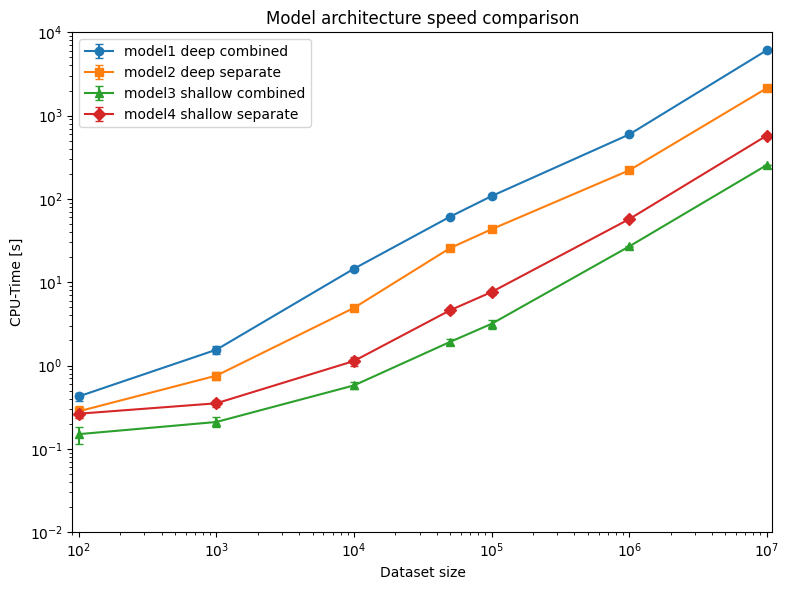

In [13]:
# Plot
fig, ax = plt.subplots(figsize=(8, 6))

colors = ['C0', 'C1', 'C2', 'C3']
markers = ['o', 's', '^', 'D']
labels = [
    r'model1 deep combined',
    r'model2 deep separate',
    r'model3 shallow combined',
    r'model4 shallow separate'
]

for i, ((model_name, means), label) in enumerate(zip(model_prediction_times.items(), labels)):
    stds = model_prediction_stds[model_name]
    ax.errorbar(
        data_sizes_pred,
        means,
        yerr=stds,
        label=label,
        color=colors[i % len(colors)],
        marker=markers[i % len(markers)],
        linestyle='-',
        capsize=3
    )

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(90, 1.1e7)
ax.set_ylim(1e-2, 1e4)

ax.set_ylabel('CPU-Time [s]')
ax.set_xlabel('Dataset size')
ax.set_title('Model architecture speed comparison')

plt.legend()
plt.tight_layout()
plt.savefig(f'../Plots/FinalExamples/CpuTimeComparison_NNonly.png', dpi=600)
plt.show()

In [ ]:
def count_params(model):
    return model.count_params()

params_model1 = count_params(model1)
params_model2 = count_params(model2_1halo) + count_params(model2_2halo)
params_model3 = count_params(model3)
params_model4 = count_params(model4_1halo) + count_params(model4_2halo)

print(f"Model 1: {params_model1:,} trainierbare Weights")
print(f"Model 2: {params_model2:,} trainierbare Weights (1-halo + 2-halo)")
print(f"Model 3: {params_model3:,} trainierbare Weights")
print(f"Model 4: {params_model4:,} trainierbare Weights (1-halo + 2-halo)")

Model 1: 10,405,734 trainierbare Weights
Model 2: 1,925,469 trainierbare Weights (1-halo + 2-halo)
Model 3: 535,032 trainierbare Weights
Model 4: 848,503 trainierbare Weights (1-halo + 2-halo)


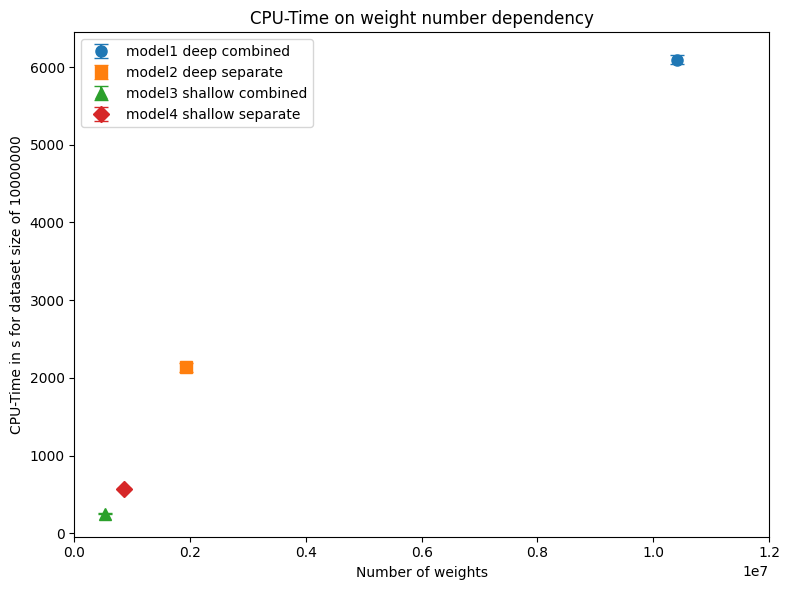

[6093.106, 2134.369, 254.86699999999837, 576.0950000000012]
[58.48145128158297, 63.80908061553803, 2.876560619912476, 6.98091663035852]


In [15]:
max_data_size = max(data_sizes_pred)

# Arrays der Parameteranzahl je Modell
params = [
    params_model1,
    params_model2,
    params_model3,
    params_model4
]

model_names = [
    "model1 deep combined",
    "model2 deep separate",
    "model3 shallow combined",
    "model4 shallow separate"
]

colors = ['C0', 'C1', 'C2', 'C3']
markers = ['o', 's', '^', 'D']

# Zeiten + Std für größte Dataset-Größe
times_at_max_size = []
stds_at_max_size = []
max_index = data_sizes_pred.index(max_data_size)

for model_name in model_prediction_times.keys():
    times = model_prediction_times[model_name]
    stds = model_prediction_stds[model_name]
    times_at_max_size.append(times[max_index])
    stds_at_max_size.append(stds[max_index])

# Plot
plt.figure(figsize=(8,6))

for i in range(len(params)):
    plt.errorbar(
        params[i],
        times_at_max_size[i],
        yerr=stds_at_max_size[i],
        fmt=markers[i],
        color=colors[i],
        capsize=5,
        label=model_names[i],
        markersize=8,
        linestyle='none'
    )

plt.xscale('linear')
plt.yscale('linear')
plt.xlabel('Number of weights')
plt.ylabel(f'CPU-Time in s for dataset size of {max_data_size}')
plt.title('CPU-Time on weight number dependency')
plt.xlim(0, 12e6)
plt.legend()
plt.tight_layout()
plt.savefig(f'../Plots/FinalExamples/CpuTimeComparisonWeightpng', dpi=600)
plt.show()
print(times_at_max_size)
print(stds_at_max_size)


In [16]:
import re

# Beispiel: Datei mit 500 Zeilen (ersetze ggf. durch deinen Pfad)
log_file = "training_runsv3.txt"

# Set zur Speicherung gültiger Kombinationen
valid_combinations = set()

# Muster für das Parsen der Werte aus jeder Zeile
pattern = re.compile(
    r"validation loss=([\d\.eE+-]+).*?params=\{.*?'activation': '(\w+)', 'optimizer': '(\w+)'"
)

with open(log_file, "r") as f:
    for line in f:
        match = pattern.search(line)
        if match:
            val_loss = float(match.group(1))
            activation = match.group(2)
            optimizer = match.group(3)

            #if val_loss < 0.001:
            valid_combinations.add((optimizer, activation))

# Ausgabe der einzigartigen Kombinationen
print("Optimizer + Activation Kombinationen mit val_loss < 0.001:")
for optimizer, activation in sorted(valid_combinations):
    print(f"Optimizer: {optimizer}, Activation: {activation}")


Optimizer + Activation Kombinationen mit val_loss < 0.001:
Optimizer: AdamW, Activation: elu
Optimizer: AdamW, Activation: gelu
Optimizer: AdamW, Activation: leaky_relu
Optimizer: AdamW, Activation: relu
Optimizer: AdamW, Activation: selu
Optimizer: AdamW, Activation: sigmoid
Optimizer: AdamW, Activation: swish
Optimizer: AdamW, Activation: tanh
Optimizer: RAdam, Activation: elu
Optimizer: RAdam, Activation: gelu
Optimizer: RAdam, Activation: leaky_relu
Optimizer: RAdam, Activation: relu
Optimizer: RAdam, Activation: selu
Optimizer: RAdam, Activation: sigmoid
Optimizer: RAdam, Activation: swish
Optimizer: RAdam, Activation: tanh
Optimizer: adam, Activation: elu
Optimizer: adam, Activation: gelu
Optimizer: adam, Activation: leaky_relu
Optimizer: adam, Activation: relu
Optimizer: adam, Activation: selu
Optimizer: adam, Activation: sigmoid
Optimizer: adam, Activation: swish
Optimizer: adam, Activation: tanh
Optimizer: rmsprop, Activation: elu
Optimizer: rmsprop, Activation: gelu
Optimizer

In [ ]:
import ast

results = []

with open("training_runsv3.txt", "r") as f:
    for line in f:
        # Extrahiere val_loss
        val_loss_str = line.split("validation loss=")[1].split(",")[0]
        val_loss = float(val_loss_str)

        # Extrahiere den Dictionary-Teil
        params_str = line.split("params=")[1].strip()
        params = ast.literal_eval(params_str)  # sicherer als eval

        results.append((params, val_loss))


/tmp/ipykernel_896324/2675396545.py:113: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(lim_low, lim_high)
/tmp/ipykernel_896324/2675396545.py:113: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(lim_low, lim_high)
/tmp/ipykernel_896324/2675396545.py:113: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(lim_low, lim_high)
/tmp/ipykernel_896324/2675396545.py:113: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(lim_low, lim_high)
/tmp/ipykernel_896324/2675396545.py:106: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(lim_low, lim_high)


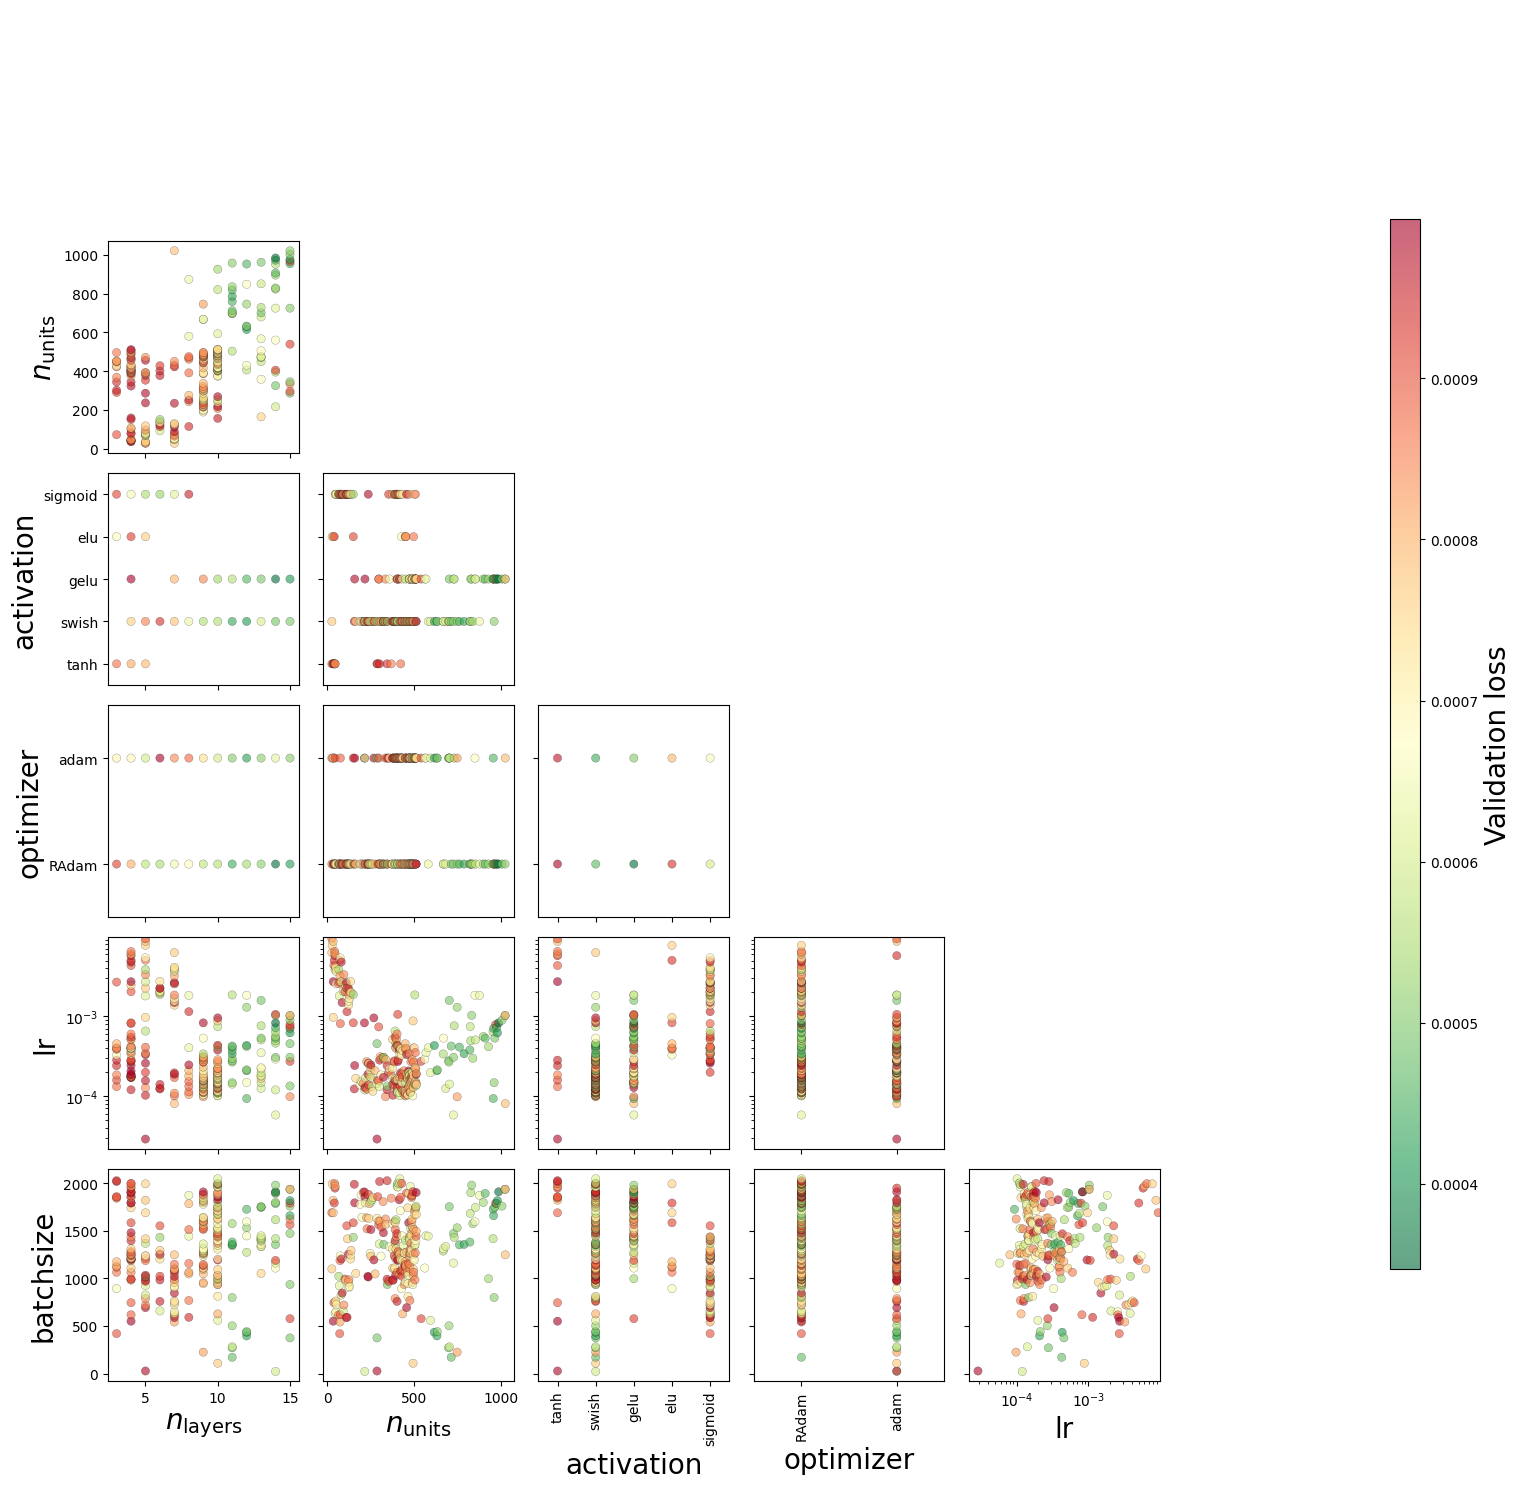

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Threshold definieren
VAL_LOSS_THRESHOLD = 1

# results ist eine Liste von Tupeln: (params_dict, val_loss)
# Beispiel: results = [({"n_layers": ..., "activation": ..., ...}, 0.0008), ...]

# 1. Filtere gültige Optimizer-Kombinationen mit val_loss < THRESHOLD
allowed_optimizers = {
    p['optimizer']
    for p, v in results
    if v < VAL_LOSS_THRESHOLD
}

# 2. Filtere alle Ergebnisse, die zu diesen Optimizern gehören
filtered_results = [
    (p, v)
    for p, v in results
    if p['optimizer'] in allowed_optimizers
]

# 3. DataFrame aus den gefilterten Ergebnissen
df = pd.DataFrame([p for p, _ in filtered_results])
df["val_loss"] = [v for _, v in filtered_results]

# ➕ Filter: nur Einträge mit val_loss < 0.01 behalten
df = df[df["val_loss"] < 0.001]

# Parameterbeschriftungen (für Achsen)
param_names = [r'$n_\mathrm{layers}$', r'$n_\mathrm{units}$', r'activation', r'optimizer', r'lr', r'batchsize']

# Konvertiere kategorische Spalten zu Zahlen
categorical_columns = ["activation", "optimizer"]
label_maps = {}

for col in categorical_columns:
    unique_vals = df[col].unique()
    mapping = {val: i for i, val in enumerate(unique_vals)}
    df[col] = df[col].map(mapping)
    label_maps[col] = {i: val for val, i in mapping.items()}

# NumPy-Arrays erzeugen
input_parameters = df.drop(columns=["val_loss"]).values
val_loss = df["val_loss"].values

# Plot-Funktion
def corner_plot(input_parameters, param_names, val_loss, label_maps):
    n_samples, n_params = input_parameters.shape
    fig, axes = plt.subplots(n_params, n_params, figsize=(2.5 * n_params, 2.5 * n_params), sharex='col', sharey='row')

    for i in range(n_params):
        for j in range(n_params):
            ax = axes[i, j]

            if i < j:
                ax.axis("off")
                continue

            elif i == j:
                ax.axis("off")  # Histogramm entfernen

            else:
                x = input_parameters[:, j]
                y = input_parameters[:, i]

                # Deduplizieren: Für jedes (x,y)-Paar nur den minimalen val_loss behalten
                df_points = pd.DataFrame({'x': x, 'y': y, 'val_loss': val_loss})
                df_min = df_points.groupby(['x', 'y'], as_index=False).min()

                x_dedup = df_min['x'].values
                y_dedup = df_min['y'].values
                val_loss_dedup = df_min['val_loss'].values

                sc = ax.scatter(x_dedup, y_dedup,
                                c=val_loss_dedup,
                                cmap="RdYlGn_r",
                                alpha=0.6,
                                edgecolor="k", linewidth=0.2)

                for axis, arr, idx in zip(['x', 'y'], [x_dedup, y_dedup], [j, i]):
                    param_key = param_names[idx].strip('$').lower()
                    min_val, max_val = np.min(arr), np.max(arr)

                    if param_key in label_maps:
                        ticks = sorted(label_maps[param_key].keys())
                        labels = [label_maps[param_key][t] for t in ticks]
                        lim_low = min_val - 0.5
                        lim_high = max_val + 0.5
                    else:
                        ticks = None
                        labels = None
                        if max_val != min_val:
                            padding = 0.05 * (max_val - min_val)
                        else:
                            padding = 0.1
                        lim_low = min_val - padding
                        lim_high = max_val + padding

                    # ⬇️ Hier wird log-Skalierung für 'lr' gesetzt
                    if axis == 'x':
                        if param_key == 'lr':
                            ax.set_xscale('log')
                        ax.set_xlim(lim_low, lim_high)
                        if ticks is not None:
                            ax.set_xticks(ticks)
                            ax.set_xticklabels(labels, rotation=90)
                    else:
                        if param_key == 'lr':
                            ax.set_yscale('log')
                        ax.set_ylim(lim_low, lim_high)
                        if ticks is not None:
                            ax.set_yticks(ticks)
                            ax.set_yticklabels(labels)


                if i == n_params - 1:
                    ax.set_xlabel(param_names[j], fontsize=20)
                if j == 0:
                    ax.set_ylabel(param_names[i], fontsize=20)

    fig.tight_layout()
    fig.subplots_adjust(right=0.92)
    cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(sc, cax=cbar_ax)
    cbar.set_label('Validation loss', fontsize=20)
    plt.savefig('../Plots/Examples/HyperparameterOpti.png', dpi=900)
    plt.show()

# Plot aufrufen
corner_plot(input_parameters, param_names, val_loss, label_maps)


/tmp/ipykernel_896324/2209637659.py:116: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(lim_low, lim_high)
/tmp/ipykernel_896324/2209637659.py:116: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(lim_low, lim_high)
/tmp/ipykernel_896324/2209637659.py:116: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(lim_low, lim_high)
/tmp/ipykernel_896324/2209637659.py:116: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(lim_low, lim_high)
/tmp/ipykernel_896324/2209637659.py:109: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(lim_low, lim_high)


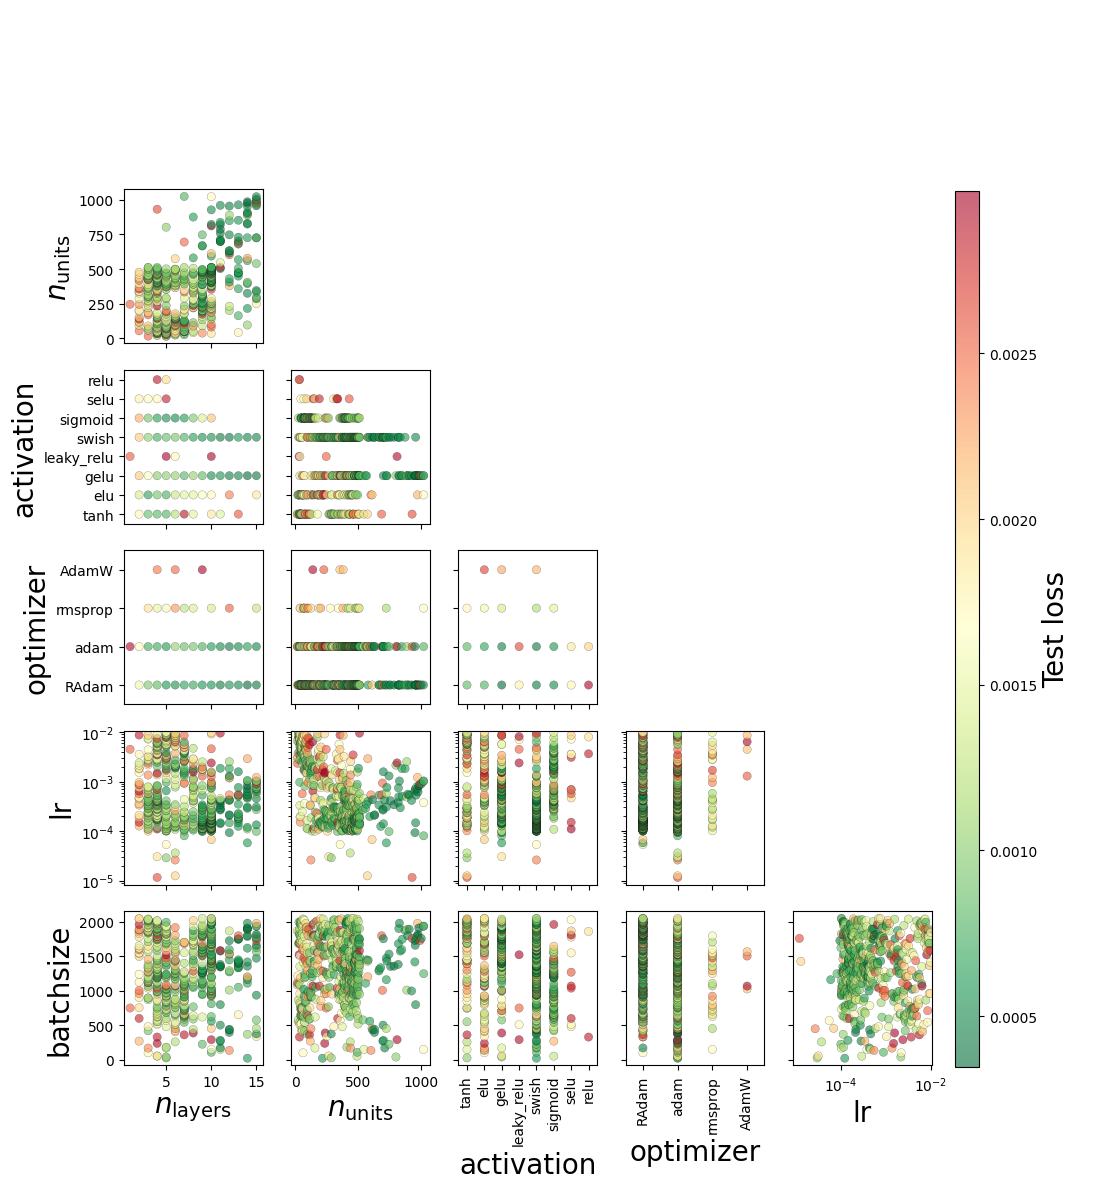

In [19]:
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Testverluste aus Datei lesen
test_loss_dict = {}
with open("test_losses.txt", "r") as f:
    for line in f:
        if "test loss" in line:
            parts = line.strip().split(": test loss = ")
            if len(parts) == 2:
                date = parts[0].strip()
                test_loss = float(parts[1])
                test_loss_dict[date] = test_loss

# 2. training_runsv3.txt einlesen

results = []

with open("training_runsv3.txt", "r") as f:
    for line in f:
        # Extrahiere val_loss
        val_loss_str = line.split("validation loss=")[1].split(",")[0]
        val_loss = float(val_loss_str)

        # Extrahiere den Dictionary-Teil
        params_str = line.split("params=")[1].strip()
        params = ast.literal_eval(params_str)  # sicherer als eval

        results.append((params, val_loss))

# 3. Pandas DataFrame erstellen
df = pd.DataFrame([p for p, _ in results])
df["test_loss"] = [v for _, v in results]

# ➕ Filter: nur Einträge mit test_loss < 0.003
df = df[df["test_loss"] < 0.003]

# Parameterbeschriftungen (für Achsen)
param_names = [r'$n_\mathrm{layers}$', r'$n_\mathrm{units}$', r'activation', r'optimizer', r'lr', r'batchsize']

# 4. Kategorische Spalten zu Zahlen konvertieren
categorical_columns = ["activation", "optimizer"]
label_maps = {}

for col in categorical_columns:
    if col in df.columns:
        unique_vals = df[col].unique()
        mapping = {val: i for i, val in enumerate(unique_vals)}
        df[col] = df[col].map(mapping)
        label_maps[col] = {i: val for val, i in mapping.items()}

# 5. NumPy-Arrays erzeugen
input_parameters = df.drop(columns=["test_loss"]).values
loss_values = df["test_loss"].values

# 6. Corner-Plot Funktion
def corner_plot(input_parameters, param_names, loss_values, label_maps):
    n_samples, n_params = input_parameters.shape
    fig, axes = plt.subplots(n_params, n_params, figsize=(2 * n_params, 2 * n_params), sharex='col', sharey='row')

    for i in range(n_params):
        for j in range(n_params):
            ax = axes[i, j]

            if i < j:
                ax.axis("off")
                continue
            elif i == j:
                ax.axis("off")  # Histogramm entfernen
            else:
                x = input_parameters[:, j]
                y = input_parameters[:, i]

                # Deduplizieren
                df_points = pd.DataFrame({'x': x, 'y': y, 'loss': loss_values})
                df_min = df_points.groupby(['x', 'y'], as_index=False).min()

                x_dedup = df_min['x'].values
                y_dedup = df_min['y'].values
                loss_dedup = df_min['loss'].values

                sc = ax.scatter(x_dedup, y_dedup,
                                c=loss_dedup,
                                cmap="RdYlGn_r",
                                alpha=0.6,
                                edgecolor="k", linewidth=0.2)

                for axis, arr, idx in zip(['x', 'y'], [x_dedup, y_dedup], [j, i]):
                    param_key = param_names[idx].strip('$').lower()
                    min_val, max_val = np.min(arr), np.max(arr)

                    if param_key in label_maps:
                        ticks = sorted(label_maps[param_key].keys())
                        labels = [label_maps[param_key][t] for t in ticks]
                        lim_low = min_val - 0.5
                        lim_high = max_val + 0.5
                    else:
                        ticks = None
                        labels = None
                        padding = 0.05 * (max_val - min_val) if max_val != min_val else 0.1
                        lim_low = min_val - padding
                        lim_high = max_val + padding

                    if axis == 'x':
                        if param_key == 'lr':
                            ax.set_xscale('log')
                        ax.set_xlim(lim_low, lim_high)
                        if ticks is not None:
                            ax.set_xticks(ticks)
                            ax.set_xticklabels(labels, rotation=90)
                    else:
                        if param_key == 'lr':
                            ax.set_yscale('log')
                        ax.set_ylim(lim_low, lim_high)
                        if ticks is not None:
                            ax.set_yticks(ticks)
                            ax.set_yticklabels(labels)

                if i == n_params - 1:
                    ax.set_xlabel(param_names[j], fontsize=20)
                if j == 0:
                    ax.set_ylabel(param_names[i], fontsize=20)

    fig.tight_layout()
    fig.subplots_adjust(right=0.92)
    cbar_ax = fig.add_axes([0.8, 0.106, 0.02, 0.73])
    cbar = fig.colorbar(sc, cax=cbar_ax)
    cbar.set_label('Test loss', fontsize=20)
    plt.savefig('../Plots/Examples/HyperparameterOpti_TESTLOSS.png', dpi=900)
    plt.show()

# 7. Plot aufrufen
corner_plot(input_parameters, param_names, loss_values, label_maps)
